# Projekt 2 - Stworzenie modelu na bazie RPR

Odtworzyliśmy procedurę opisaną w artykule 6 o RPR

#### Importowanie bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

## Deadline I

#### Wczytanie danych

Dane pobrane z proponowanej strony - https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE48262

Dane dotyczą komórki pierwszej cell1.txt

In [2]:
data_hic = np.genfromtxt('cell1.txt', dtype='object', skip_header=1)

In [3]:
data_hic

array([[b'1', b'3023035', b'1', b'14942225'],
       [b'1', b'3065457', b'1', b'19796342'],
       [b'1', b'3312156', b'1', b'5315667'],
       ...,
       [b'X', b'165354581', b'X', b'165359148'],
       [b'X', b'166044486', b'X', b'166058486'],
       [b'X', b'166251418', b'X', b'166367164']], dtype=object)

#### Przefiltrowanie danych - wybranie chromosomu

In [4]:
chromosome_number = b'1' 
data_filtered = data_hic[(data_hic[:, 0] == chromosome_number) & (data_hic[:, 2] == chromosome_number)]

In [5]:
data_filtered

array([[b'1', b'3023035', b'1', b'14942225'],
       [b'1', b'3065457', b'1', b'19796342'],
       [b'1', b'3312156', b'1', b'5315667'],
       ...,
       [b'1', b'196642198', b'1', b'196692230'],
       [b'1', b'196820129', b'1', b'196821712'],
       [b'1', b'196941897', b'1', b'196953158']], dtype=object)

#### Tworzenie binów

In [6]:
data_filtered = data_filtered[:, [1, 3]].astype(int)
sample_genome_size = np.max(data_filtered) + 1
sample_genome_size

196957224

#### Rozmiar binów

In [7]:
bin_size = 1000000 #1Mb
num_bins = sample_genome_size // bin_size + 1

#### Sprawdzenie, że jest ok

In [9]:
# for row in data_filtered:
#     print(row[0], row[0]//bin_size)
#     print(row[1], row[1]//bin_size)

#### Tworzenie macierzy kontaktów

In [8]:
contact_matrix = np.zeros((num_bins, num_bins))

for row in data_filtered:
    bin1 = row[0] // bin_size
    bin2 = row[1] // bin_size
    contact_matrix[bin1, bin2] += 1
    contact_matrix[bin2, bin1] += 1 

<Axes: >

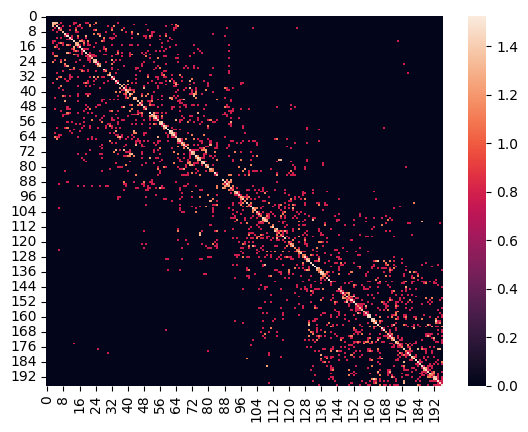

In [9]:
#sns.heatmap(contact_matrix)
sns.heatmap(np.arctan(contact_matrix))

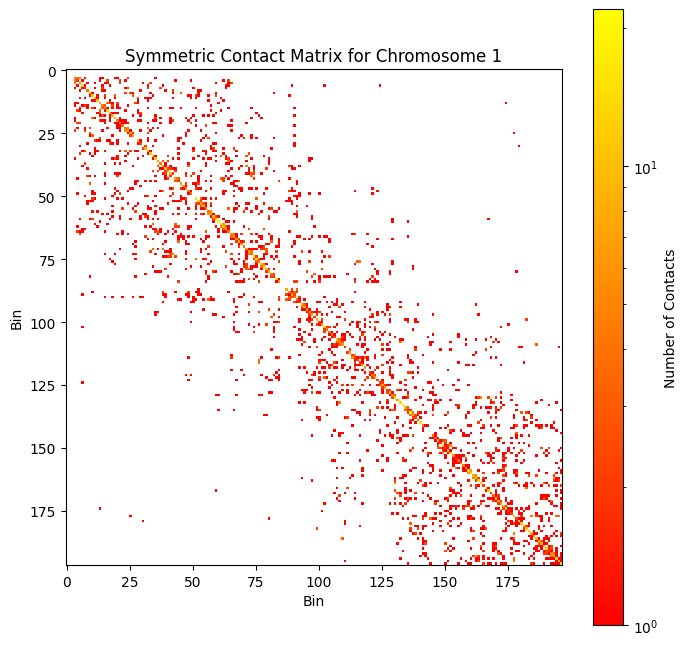

In [10]:
plt.figure(figsize=(8, 8))
plt.imshow(contact_matrix, cmap='autumn', interpolation='nearest', norm=LogNorm(vmin=1, vmax=np.max(contact_matrix)))
plt.colorbar(label='Number of Contacts')
plt.title(f'Symmetric Contact Matrix for Chromosome {chromosome_number.decode()}')
plt.xlabel('Bin')
plt.ylabel('Bin')
plt.show()

#### Wszystko w jednej funkcji:

In [11]:
def calc_contact_matrix(data_hic, chromosome_numbers, bin_size):
    data_filtered = data_hic[np.isin(data_hic[:, 0].astype(str), chromosome_numbers) & np.isin(data_hic[:, 2].astype(str), chromosome_numbers)]
    data_filtered = data_filtered[:, [1, 3]].astype(int)
    sample_genome_size = np.max(data_filtered) + 1

    bin_size = bin_size
    num_bins = sample_genome_size // bin_size + 1
    
    contact_matrix = np.zeros((num_bins, num_bins))
    for row in data_filtered:
        bin1 = row[0] // bin_size
        bin2 = row[1] // bin_size
        contact_matrix[bin1, bin2] += 1
        contact_matrix[bin2, bin1] += 1 
    
    return contact_matrix

Tu wybrany został chromosom X

In [13]:
cm=calc_contact_matrix(data_hic, ['X'], 1000000)
cm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 6., 1., 0.],
       [0., 0., 0., ..., 1., 4., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

<Axes: >

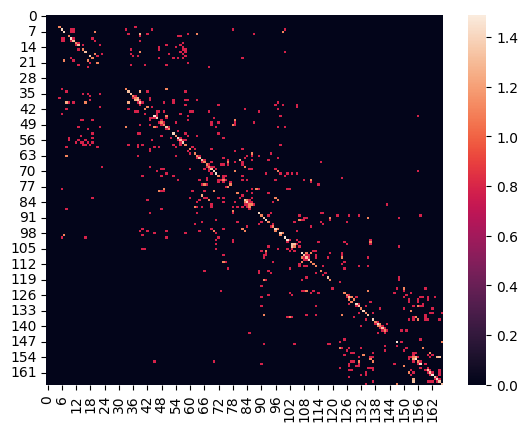

In [14]:
sns.heatmap(np.arctan(cm))

#### Wykres RPR

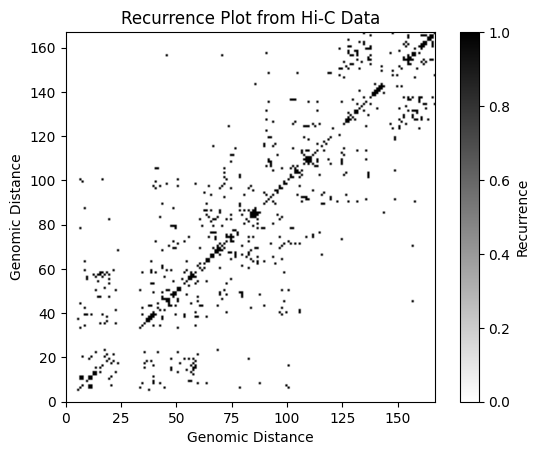

In [15]:
def recurrence_plot_from_hic(hic_data, epsilon):
    #hic_data /= np.max(hic_data)
    
    N = len(hic_data)
    R = np.zeros((N, N))
    for k in range(N):
        for l in range(N):
            if np.abs(hic_data[k, l]) >= epsilon:
                R[k, l] = 1

    return R

hic_data = cm 

epsilon = 1

recurrence_matrix = recurrence_plot_from_hic(hic_data, epsilon)

plt.imshow(recurrence_matrix, cmap='binary', origin='lower', extent=[0, len(hic_data), 0, len(hic_data)])
plt.title('Recurrence Plot from Hi-C Data')
plt.xlabel('Genomic Distance')
plt.ylabel('Genomic Distance')
plt.colorbar(label='Recurrence')
plt.show()

## Deadline II 

#### Utworzenie grafu ważonego sąsiadujących loci

Importowanie potrzebnych bibliotek do tworzenia grafu i zapisania danych do wizulaizacji w chimerze

In [17]:
#pip install networkx
import networkx as nx

In [ ]:
!pip install git+https://bitbucket.org/4dnucleome/points_io.git
from points_io import save_points_as_pdb

Sprowadzenie macierzy kontaktów do postaci binarnej zgodnie z RPR

In [19]:
def recurrence_plot_matrix(hic_data, epsilon):
    N = len(hic_data)
    R = np.zeros((N, N))
    for k in range(N):
        for l in range(N):
            if np.abs(hic_data[k, l]) > epsilon:
                R[k, l] = 1

    return R

Tworzenie macierzy wag zgodnie ze wzorem z artykułu

In [20]:
def calculate_weight_matrix(contact_matrix):
    N = contact_matrix.shape[0]
    weight_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if contact_matrix[i, j]==1:
                intersection = np.sum((contact_matrix[i]==contact_matrix[j]) & (contact_matrix[i]==1))
                union=np.sum(contact_matrix[i])+np.sum(contact_matrix[j])-intersection
                weight_matrix[i, j] = 1 - (intersection / union)
            else:
                weight_matrix[i, j] = 1

    return weight_matrix

Zamiana macierzy na graf ważony

In [21]:
def create_weighted_graph(weight_matrix):
    N = weight_matrix.shape[0]
    G = nx.Graph()

    for i in range(N):
        for j in range(i+1, N):
            weight = weight_matrix[i, j]
            if weight > 0:  
                G.add_edge(i, j, weight=weight)
                G.nodes[i]['position'] = (i, 0) 
                G.nodes[j]['position'] = (j, 0)

    return G

## Deadline III

#### Utworzenie macierzy odległości z ważonego grafu


Obliczanie dystansów za pomocą algorytmu Dijkstry

In [47]:
def calculate_distances(graph):
    distances = np.zeros((len(graph), len(graph)))
    for source in graph.nodes:
        lengths = nx.single_source_dijkstra_path_length(graph, source)
        print(lengths)
        for target, distance in lengths.items():
            distances[source][target] = distance
    return distances

Ręczna implementacja algorytmu Dijkstry

In [ ]:
# def calculate_distances(graph):
#     num_nodes = len(graph)
#     distances = np.zeros((num_nodes, num_nodes))

#     for source in graph.nodes:
#         visited = set()
#         distances_from_source = {node: float('inf') for node in graph.nodes}
#         distances_from_source[source] = 0

#         while len(visited) < num_nodes:
#             current_node = min((node for node in graph.nodes if node not in visited),
#                                key=lambda x: distances_from_source[x])
#             visited.add(current_node)

#             for neighbor, weight in graph[current_node].items():
#                 distance_through_current = distances_from_source[current_node] + weight['weight']
#                 if distance_through_current < distances_from_source[neighbor]:
#                     distances_from_source[neighbor] = distance_through_current

#         for target in graph.nodes:
#             distances[source][target] = distances_from_source[target]

#     return distances

Sprawdzenie kolejnych kroków:

Macierz kontaktów

In [24]:
cm=calc_contact_matrix(data_hic, ['1'], 1000000)
cm

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 12.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  8.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1., 16.]])

Binarna macierz kontaktów

In [25]:
wr=recurrence_plot_matrix(cm, 0)
wr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

Graf ważony

In [42]:
wm=calculate_weight_matrix(wr)
wg=create_weighted_graph(wm)
wg
len(wg)

197

Macierz odległości

In [ ]:
distances_matrix=calculate_distances(wg)

## Deadline IV

#### Utworzenie pierwszych modeli poprzez algorytm MDS

In [ ]:
from sklearn.manifold import MDS
mds = MDS(n_components=3, dissimilarity='euclidean')
embedding = mds.fit_transform(distances_matrix)

Zapisanie danych w formacie pdb do chimery

In [29]:
save_points_as_pdb(embedding, "cell_1_2.pdb")

File cell_1_2.pdb saved...


#### Wszystko w jednej funkcji:

In [30]:
def rpr_visualisation(data_hic, num_of_chromosomes, bin_size):
    cm=calc_contact_matrix(data_hic, num_of_chromosomes, bin_size)
    wr=recurrence_plot_matrix(cm, 0)
    wm=calculate_weight_matrix(wr)
    wg=create_weighted_graph(wm)
    distances_matrix=calculate_distances(wg)
    mds = MDS(n_components=3, dissimilarity='euclidean')
    embedding = mds.fit_transform(distances_matrix)
    return embedding


In [ ]:
save_points_as_pdb(rpr_visualisation(data_hic, num_of_chromosomes=['1'], bin_size=2000000), "cell_1_2.pdb")


# ![](chimera1.png)